# Looking at the Data Level 2


In this notebook we will analyze Crab DL2 collected with MAGIC+LST1 in several nights scattered over 2020 and 2021. We will build a counts map, check the achieved angular resolution, check the offset ($\theta$) of the reconstructed target position in relation to the real target position. We will start, however, by taking a closer look into the data itself.


### Let's start by loading some useful modules

In [104]:
import glob
import itertools
from pathlib import Path
import numpy as np
import pandas as pd
from pyirf.benchmarks import angular_resolution
from astropy import units as u
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord
from gammapy.stats import WStatCountsStatistic
from magicctapipe.io import get_dl2_mean, get_stereo_events
from magicctapipe.utils import calculate_off_coordinates
from matplotlib import pyplot as plt

In [105]:
# Display all the columns of a pandas data frame
pd.set_option("display.max_columns", None)

# Customize the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "dotted"}
)

# Get the pyplot default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load input DL2 data files

The data used here is available at the IT Container or at PIC.  

In this example we download the data to the directory ./data/  
Let's start by listing the input files with _glob_:

In [106]:
input_file_mask = './data/*.h5' #e.g. my/path/to/the/data/*.h5

# Find the input files
input_files = glob.glob(input_file_mask)
input_files.sort()

Now let's read all of the data files and concatenate them in a single variable `event_data`:

In [107]:
print("The following files are found:")

data_list = []

for input_file in input_files:

    print(Path(input_file).name)

    # Load the input file
    df_events = pd.read_hdf(input_file, key="events/parameters")
    data_list.append(df_events)

event_data = pd.concat(data_list)
event_data.set_index(["obs_id", "event_id", "tel_id"], inplace=True)
event_data.sort_index(inplace=True)

The following files are found:
dl2_LST-1_MAGIC.Run03266.h5
dl2_LST-1_MAGIC.Run03636.h5


Now let's apply a quality cut to the data packed in the table "event_data" and take a look at it. We see that most of the stereo events (i.e. those detected with at least 2 telescopes) are detected by all three telescopes. Note that the "events" here are not just photons. They can be protons, electrons etc

In [108]:
quality_cuts = f"(disp_diff_mean < {np.sqrt(0.05)})"

# Apply the quality cuts
print(f"\nQuality cuts: {quality_cuts}")
event_data = get_stereo_events(event_data, quality_cuts)


Quality cuts: (disp_diff_mean < 0.22360679774997896)



In total 41736 stereo events are found:
    M1_M2 (type 0): 8319 events (19.9%)
    LST1_M1 (type 1): 3416 events (8.2%)
    LST1_M2 (type 2): 8857 events (21.2%)
    LST1_M1_M2 (type 3): 21144 events (50.7%) 


Now we exclude the MAGIC-stereo combination events, since they are poorly reconstructred with the current analysis scheme. This means that we are sacrificing the 8319 stereo MAGIC events that we just saw.

In [109]:
print("Excluding the MAGIC-stereo combination events...")
event_data.query("combo_type != 0", inplace=True)

Excluding the MAGIC-stereo combination events...


Let's take a look at the table "event_data", so we understand better how DL2 looks like:

In [110]:
# Show the data frame
event_data.head()

obs_id_magic  event_id_magic  obs_id_lst  \
obs_id event_id tel_id                                             
3266   192      1            5093712           45233      3266.0   
                2            5093712           45233      3266.0   
                3            5093712           45233      3266.0   
       388      1            5093712           45245      3266.0   
                3            5093712           45245      3266.0   

                        event_id_lst    intensity         x         y  \
obs_id event_id tel_id                                                  
3266   192      1              192.0  2936.799397 -0.654824 -0.298636   
                2              192.0   298.963542 -0.258605 -0.134167   
                3              192.0  1096.882812 -0.302039 -0.243345   
       388      1              388.0   184.138179  0.390682 -0.627754   
                3              388.0    53.835938 -0.153421 -0.283490   

                               r         phi    length  length_uncertainty  \
obs_id event_id tel_id                                                       
3266   192      1       0.719706 -155.484410  0.104853            0.002872   
                2       0.291337 -152.579363  0.058745            0.001815   
                3       0.387871 -141.142528  0.066844            0.001389   
       388      1       0.739396  -58.103957  0.150956            0.007824   
                3       0.322342 -118.421747  0.027150            0.002077   

                           width  width_uncertainty        psi  skewness  \
obs_id event_id tel_id                                                     
3266   192      1       0.042530           0.001411  68.256231  0.667374   
                2       0.025888           0.001203  45.367122 -0.009544   
                3       0.046188           0.001234  13.312541  0.773123   
       388      1       0.028615           0.003074 -72.360547 -0.569180   
                3       0.012661           0.000393  14.106935  0.409020   

                        kurtosis      slope  intercept  intensity_width_1  \
obs_id event_id tel_id                                                      
3266   192      1       3.105092   0.609606  19.684026           0.000000   
                2       2.142010  11.267847  14.724902           0.000000   
                3       2.895705   1.881514  15.142252           0.042692   
       388      1       1.472483   3.810770  16.530785           0.000000   
                3       2.260246  13.003075  15.696527           0.000000   

                        intensity_width_2  pixels_width_1  pixels_width_2  \
obs_id event_id tel_id                                                      
3266   192      1                0.000000         0.00000          0.0000   
                2                0.000000         0.00000          0.0000   
                3                0.140298         0.00385          0.0077   
       388      1                0.000000         0.00000          0.0000   
                3                0.000000         0.00000          0.0000   

                        n_pixels  n_islands  pointing_alt  pointing_az  \
obs_id event_id tel_id                                                   
3266   192      1             50          1      0.768654     1.512154   
                2             26          1      0.768555     1.512218   
                3             62          2      0.768593     1.512181   
       388      1             11          2      0.768657     1.512156   
                3              7          1      0.768595     1.512182   

                           timestamp  time_diff  multiplicity  combo_type  \
obs_id event_id tel_id                                                      
3266   192      1       1.608069e+09   0.000052             3           3   
                2       1.608069e+09   0.001106             3           3   
                3       1.608069e+09   0.001106 

Each event listed above has parameters from 2 or 3 telescopes. In the step below we compute the means over these DL2 parameters such that each event will be assigned with average parameters for the involved telescopes.

In [111]:
print("Calculating mean DL2 parameters...")
event_data_mean = get_dl2_mean(event_data)

# Show the data frame
event_data_mean.head()

Calculating mean DL2 parameters...


combo_type  multiplicity     timestamp  pointing_alt  \
obs_id event_id                                                         
3266   192                3             3  1.608069e+09      0.768601   
       388                2             2  1.608069e+09      0.768626   
       398                3             3  1.608069e+09      0.768603   
       819                2             2  1.608069e+09      0.768632   
       937                1             2  1.608069e+09      0.768614   

                 pointing_az  reco_energy   reco_alt    reco_az  gammaness  \
obs_id event_id                                                              
3266   192          1.512184     0.718941  42.453398  85.193803   0.291750   
       388          1.512169     0.178079  44.571643  85.786187   0.015500   
       398          1.512186     0.327772  43.172639  84.826706   0.911444   
       819          1.512171     0.098390  43.151148  86.986814   0.044250   
       937          1.512191     0.224970  44.942901  86.922005   0.914095   

                 pointing_ra  pointing_dec    reco_ra   reco_dec  
obs_id event_id                                                   
3266   192         83.263010     21.787700  85.251544  22.260654  
       388         83.261931     21.788796  82.933634  22.540685  
       398         83.263007     21.787702  84.609580  22.748400  
       819         83.261919     21.788805  84.070479  21.254147  
       937         83.262744     21.787697  82.271927  21.898371

Now we use the function `np.diff()` to take the difference between each value of timestamp and then sum up all of them to get the total exposure time.

In [112]:
time_diffs = np.diff(event_data_mean["timestamp"])
obs_time = time_diffs[time_diffs < 1].sum() * u.s

print(f"Observation time: {obs_time.to('min'):.1f}")

Observation time: 33.8 min


The timestamp is given in units of seconds. In the table shown above looks like all of the timestamps are the same, but if you look closely, they are slightly different:

In [113]:
print(event_data_mean["timestamp"].values[0])
print(event_data_mean["timestamp"].values[1])

1608068604.454923
1608068604.4960566


### Calculate the angular distances from ON and OFF regions

In order to observe the target and the background at the same time, a common practice with IACTs is to misspoint the target by a wobble angle (typically 0.4$^{\circ}$ with MAGIC) such that the target and the background points lie in the same "ring" in the camera, as shown in the figure (Archambault et al. 2017):

![wobble](./figures/wobble_Archambault_2017.png)

The region named "ON" is where our target, in this case Crab, is. From now on, we will adopt 3 OFF regions that lie in the same camera ring. Let's set the ON-OFF coordinates of our target:

In [114]:
source_name = "Crab"
n_regions_off = 3

on_coord = SkyCoord.from_name(source_name, frame="icrs")

print(f"ON coordinate ({source_name}):")
print(on_coord)

#Let's also define a size to our sky map:
xlim = on_coord.ra.to_value("deg") + np.array([2, -2])
ylim = on_coord.dec.to_value("deg") + np.array([-2, 2])

print(f"\nNumber of OFF regions: {n_regions_off}")

ON coordinate (Crab):
<SkyCoord (ICRS): (ra, dec) in deg
    (83.63333333, 22.01333333)>

Number of OFF regions: 3


For each MAGIC-LST run we have a single observation ID and a single wobble. Below we do a loop over each run and plot the skymap for the ON-OFF points as well as the center of the camera. 


Observation ID: 3266

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (82.89383095, 21.56142193)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.50560822, 21.44359053)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.01981201, 22.13080513)>


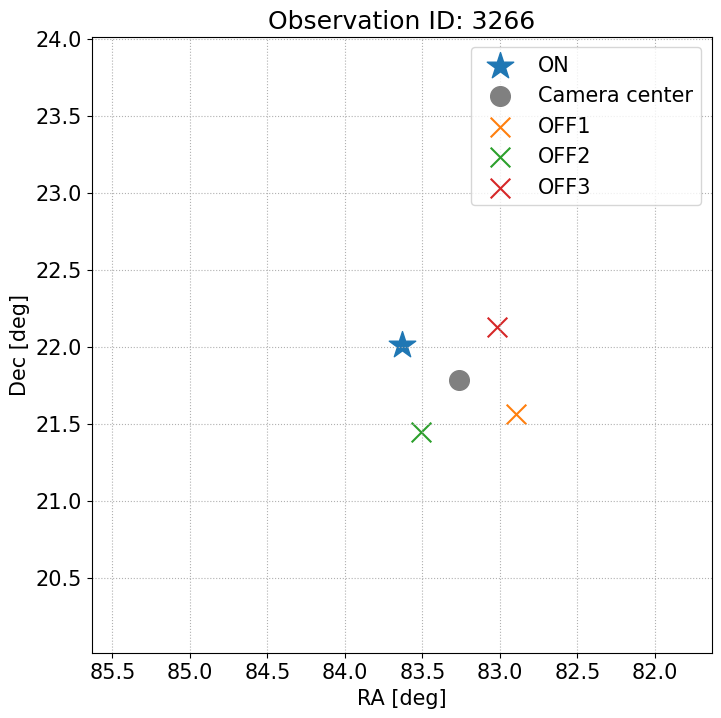


Observation ID: 3636

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.352936, 22.47746554)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.74108014, 22.57795226)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.24339648, 21.91246542)>


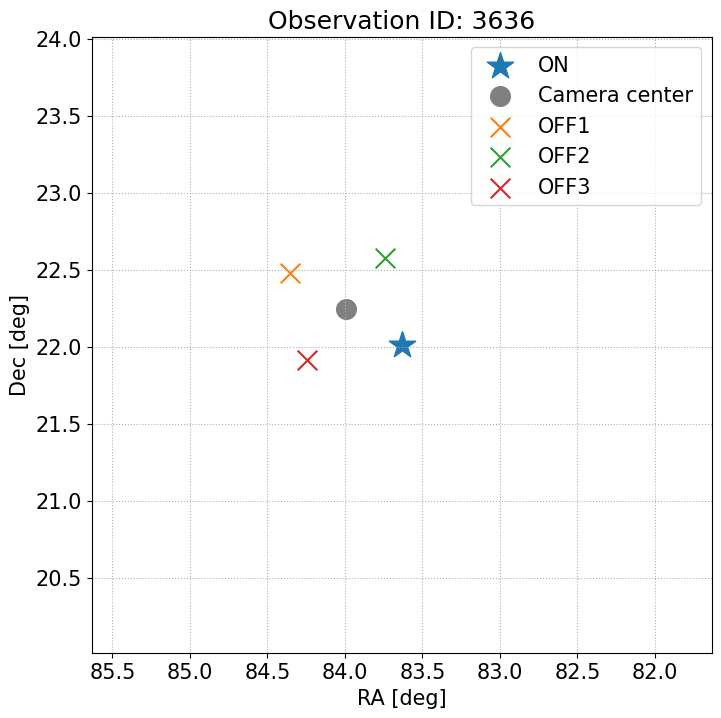

In [115]:
# Loop over every observation ID
obs_ids = np.unique(event_data_mean.index.get_level_values("obs_id"))

for obs_id in obs_ids:

    print(f"\nObservation ID: {obs_id}")
    df_events = event_data_mean.query(f"obs_id == {obs_id}")

    event_coords = SkyCoord(
        u.Quantity(df_events["reco_ra"], unit="deg"),
        u.Quantity(df_events["reco_dec"], unit="deg"),
        frame="icrs",
    )

    pnt_ra_mean = df_events["pointing_ra"].mean() * u.deg
    pnt_dec_mean = df_events["pointing_dec"].mean() * u.deg

    # Create a figure
    plt.figure(figsize=(8, 8))
    plt.title(f"Observation ID: {obs_id}")
    plt.xlabel("RA [deg]")
    plt.ylabel("Dec [deg]")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid()

    # Plot the ON coordinate
    plt.scatter(
        on_coord.ra.to("deg"), on_coord.dec.to("deg"), label="ON", marker="*", s=400
    )

    # Plot the pointing direction
    plt.scatter(
        pnt_ra_mean, pnt_dec_mean, label="Camera center", marker="o", s=200, color="grey"
    )

    # Calculate the angular distances from the ON region
    theta_on = on_coord.separation(event_coords)
    theta2_on = theta_on.to_value("deg") ** 2

    event_data_mean.loc[(obs_id, slice(None)), "theta2_on"] = theta2_on

    # Calculate the OFF coordinates
    off_coords = calculate_off_coordinates(
        pointing_ra=pnt_ra_mean,
        pointing_dec=pnt_dec_mean,
        on_coord_ra=on_coord.ra,
        on_coord_dec=on_coord.dec,
        n_regions=n_regions_off,
    )

    # Loop over every OFF coordinate
    print("\nOFF coordinates:")

    for i_off, off_coord in off_coords.items():

        print(off_coord)

        # Calculate the angular distance from the OFF coordinate
        theta_off = off_coord.separation(event_coords)
        theta2_off = theta_off.to_value("deg") ** 2

        event_data_mean.loc[(obs_id, slice(None)), f"theta2_off{i_off}"] = theta2_off

        # Plot the OFF coordinate
        plt.scatter(
            off_coord.ra.to("deg"),
            off_coord.dec.to("deg"),
            label=f"OFF{i_off}",
            marker="x",
            s=200,
            color=colors[i_off],
        )

    plt.legend()
    plt.show()

### Getting the list of photons

We now select only the events seen by all 3 telescopes and with a high probability (i.e. _gammaness_) of being gamma rays.

In [116]:
# Only events observed with all 3 telescopes:
combo_types = [3] # You can play with different combinations, e.g. with [2,3], or [2] 
# Only events observed with high prob of being gamma rays:
cut_value_gh = 0.8

print(f"Combination types: {combo_types}")
print(f"Global gammaness cut: {cut_value_gh}")

# Get the photon list
event_list = event_data_mean.query(
    f"(combo_type == {combo_types}) & (gammaness > {cut_value_gh})"
).copy()

print(f"\nNumber of events: {len(event_list)}")

# Show the event list
event_list.head()

Combination types: [3]
Global gammaness cut: 0.8

Number of events: 4843


combo_type  multiplicity     timestamp  pointing_alt  \
obs_id event_id                                                         
3266   398                3             3  1.608069e+09      0.768603   
       7064               3             3  1.608069e+09      0.768684   
       7613               3             3  1.608069e+09      0.768691   
       10799              3             3  1.608069e+09      0.768728   
       12969              3             3  1.608069e+09      0.768753   

                 pointing_az  reco_energy   reco_alt    reco_az  gammaness  \
obs_id event_id                                                              
3266   398          1.512186     0.327772  43.172639  84.826706   0.911444   
       7064         1.512227     0.211998  44.709884  86.273789   0.859421   
       7613         1.512230     0.269369  44.144170  88.563589   0.973125   
       10799        1.512249     0.401729  43.202294  89.322910   0.884159   
       12969        1.512263     0.259519  43.968726  86.057148   0.984532   

                 pointing_ra  pointing_dec    reco_ra   reco_dec  theta2_on  \
obs_id event_id                                                               
3266   398         83.263007     21.787702  84.609580  22.748400   1.355188   
       7064        83.262972     21.787661  82.676461  22.256782   0.844877   
       7613        83.262968     21.787655  82.656436  20.526631   3.038953   
       10799       83.262951     21.787618  83.387251  19.677588   5.508583   
       12969       83.262938     21.787593  83.492438  22.162110   0.039179   

                 theta2_off1  theta2_off2  theta2_off3  
obs_id event_id                                         
3266   398          3.933903     2.748762     2.540493  
       7064         0.524196     1.253519     0.116938  
       7613         1.119879     1.469403     2.687936  
       10799        3.762071     3.131043     6.136069  
       12969        0.669466     0.516419     0.192611

### Check the count map

Let's quickly do a counts map to see what we have.

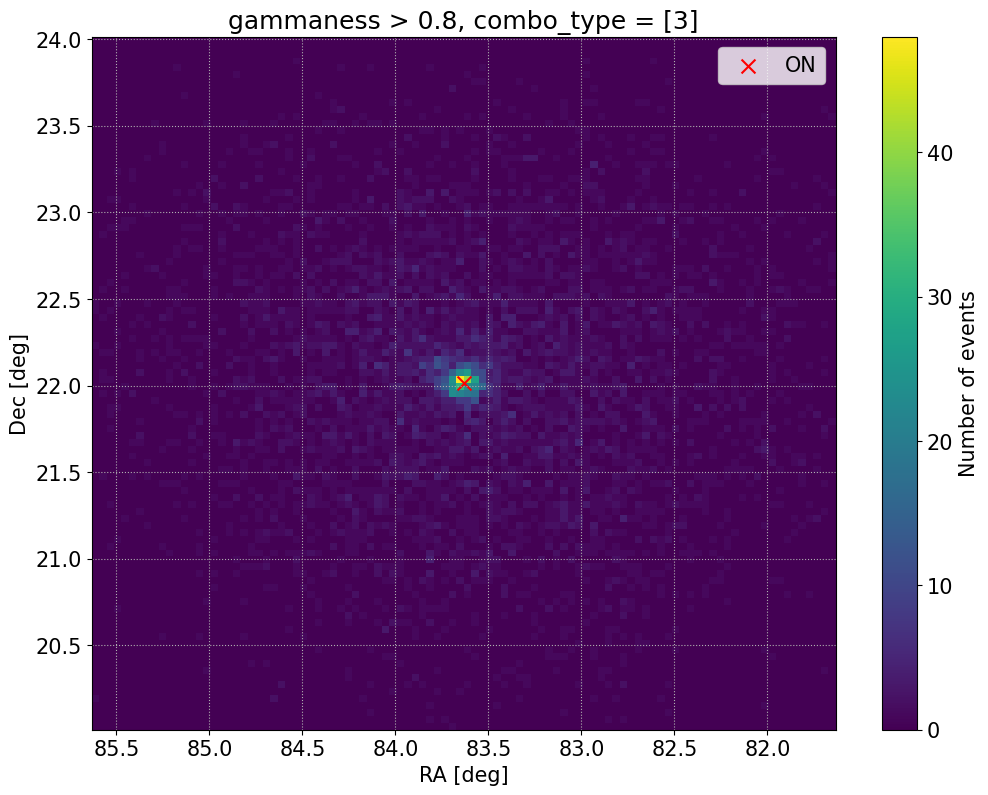

In [117]:
plt.figure()
plt.title(f"gammaness > {cut_value_gh}, combo_type = {combo_types}")
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.xlim(xlim)
plt.ylim(ylim)

# Plot the count map
plt.hist2d(
    event_list["reco_ra"],
    event_list["reco_dec"],
    bins=[np.linspace(xlim[1], xlim[0], 101), np.linspace(ylim[0], ylim[1], 101)],
)

plt.colorbar(label="Number of events")
plt.axis(xlim.tolist() + ylim.tolist())
plt.grid()

# Plot the ON coordinate
plt.scatter(
    on_coord.ra.to("deg"),
    on_coord.dec.to("deg"),
    marker="x",
    s=100,
    color="red",
    label="ON",
)

plt.legend()

### Check the $\theta^2$ distributions

$\theta$ is defined as the offset angle between the real position of the target and the reconstructed position for a single event, as shown in the figure below:

![theta](./figures/theta.png)

The $\theta^2$ distribution gives us a sort of point spread function for the IACT.

So let's start by setting up a range at which we want to look for events, let's say from 0 to 0.9$^{\circ}$, and let's also define a cutting value at $\theta = 0.2^{\circ}$ (or $\theta^2 = 0.04^{\circ}$):

In [118]:
theta2_bins = np.linspace(0, 0.9, 81)  # unit: [deg2]
cut_value_theta2 = 0.04  # unit: [deg2]

theta2_bins_center = (theta2_bins[:-1] + theta2_bins[1:]) / 2

theta2_bins_width = [
    theta2_bins_center - theta2_bins[:-1],
    theta2_bins[1:] - theta2_bins_center,
]

Now let's plot this distribution and compute the significance of the Crab signal.
Since the distribution of photons is not Poissonian, the proper way to go is using the Li & Ma significance (https://arxiv.org/abs/astro-ph/0411660).

Global theta2 cut: 0.04 [deg2]

Non: 794

Noff1: 116
Noff2: 122
Noff3: 144
--> Total Noff: 382

alpha = 0.333
--> Scaled Noff: 127

Nexcess: 667
Observation time: 33.8 min
--> Excess rate: 19.7 [1/min]

Li&Ma significance: 30.6 sigma


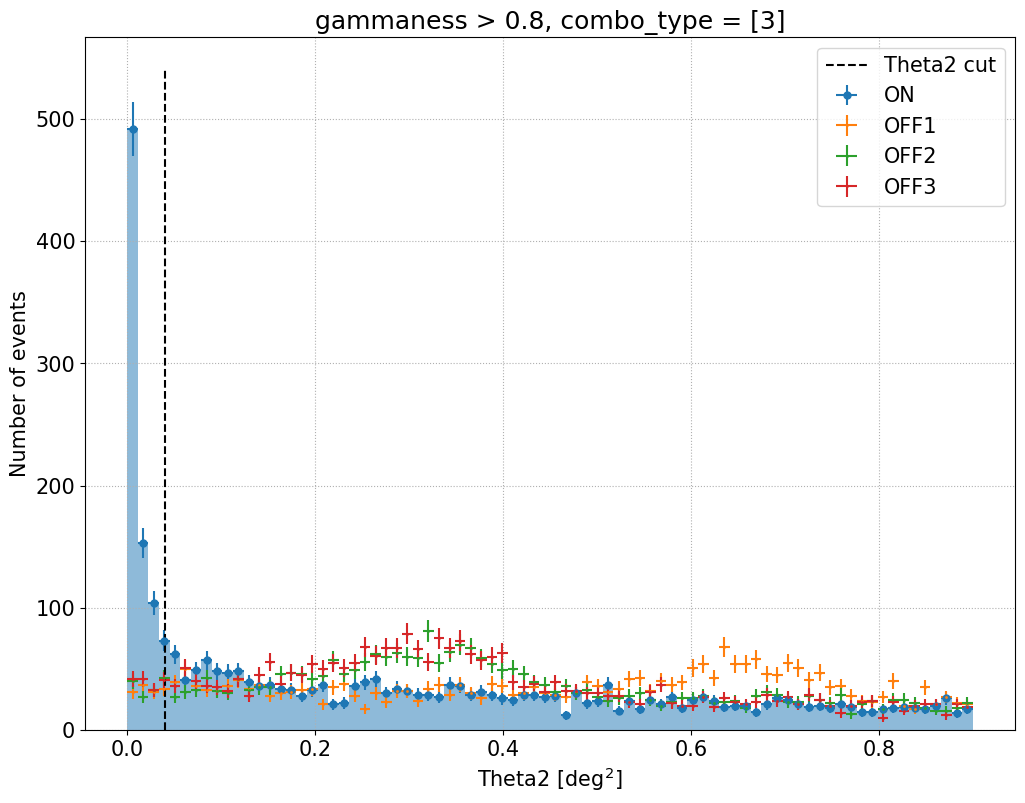

In [120]:
plt.figure()
plt.title(f"gammaness > {cut_value_gh}, combo_type = {combo_types}")
plt.xlabel("Theta2 [deg$^2$]")
plt.ylabel("Number of events")
plt.grid()

# Plot the theta2 distribution from the ON coordinate
hist_on = plt.hist(
    event_list["theta2_on"], bins=theta2_bins, histtype="bar", linewidth=2, alpha=0.5
)[0]

plt.errorbar(
    x=theta2_bins_center,
    y=hist_on,
    xerr=theta2_bins_width,
    yerr=np.sqrt(hist_on),
    fmt="o",
    markersize=5,
    label="ON",
    color=colors[0],
)

# Plot the theta2 distrubutions from the OFF coordinates
for i_off in range(n_regions_off):

    hist_off, _ = np.histogram(event_list[f"theta2_off{i_off+1}"], bins=theta2_bins)

    plt.errorbar(
        x=theta2_bins_center,
        y=hist_off,
        xerr=theta2_bins_width,
        yerr=np.sqrt(hist_off),
        fmt="o",
        markersize=1,
        label=f"OFF{i_off+1}",
    )

# Plot the theta2 cut
print(f"Global theta2 cut: {cut_value_theta2} [deg2]")

plt.plot(
    np.repeat(cut_value_theta2, 2),
    (0, plt.ylim()[1]),
    linestyle="--",
    color="black",
    label=f"Theta2 cut",
)

plt.legend(loc="upper right")

# Calculate the numbers ON, OFF and excess events
n_on = len(event_list.query(f"theta2_on < {cut_value_theta2}"))
print(f"\nNon: {n_on}\n")

n_off_total = 0

for i_off in range(n_regions_off):

    n_off = len(event_list.query(f"theta2_off{i_off+1} < {cut_value_theta2}"))
    print(f"Noff{i_off+1}: {n_off}")

    n_off_total += n_off

print(f"--> Total Noff: {n_off_total}")

alpha = 1 / n_regions_off
n_off_scaled = n_off_total * alpha

print(f"\nalpha = {alpha:.3f}")
print(f"--> Scaled Noff: {n_off_scaled:.0f}")

n_excess = n_on - n_off_scaled
excess_rate = n_excess / obs_time.to_value("min")

print(f"\nNexcess: {n_excess:.0f}")
print(f"Observation time: {obs_time.to('min'):.1f}")
print(f"--> Excess rate: {excess_rate:.1f} [1/min]")

# Calculate the Li&Ma significance
stat = WStatCountsStatistic(n_on, n_off_total, alpha=alpha)
significance = stat.sqrt_ts

print(f"\nLi&Ma significance: {significance:.1f} sigma")

We now repeat the process, but this time slicing the data in different energy bins. We see that the distribution of events gets tighter and the background drops for higher energies.

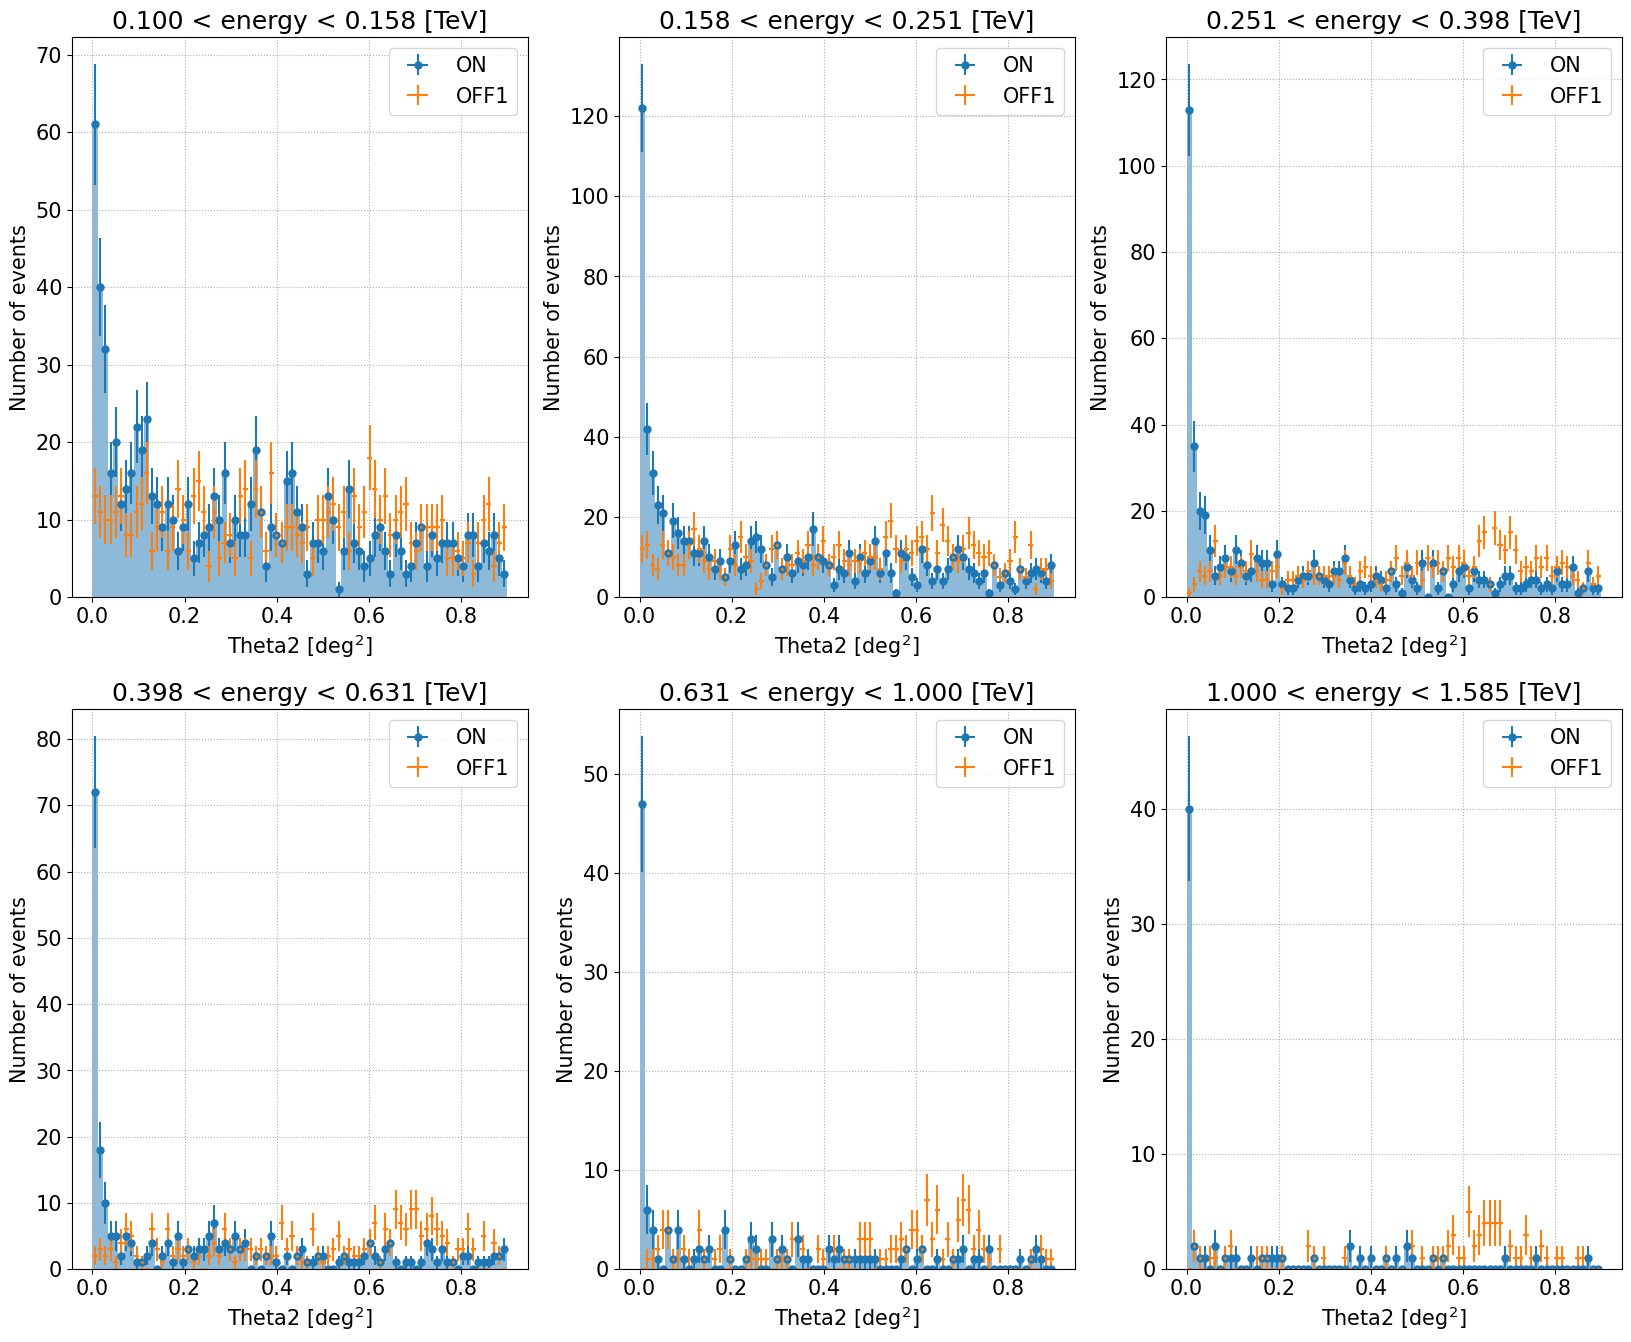

In [121]:
# ================
# === Settings ===
# ================

energy_bins = np.logspace(-1, 1, 11)[:-4]

energy_bins_center = (energy_bins[:-1] + energy_bins[1:]) / 2

energy_bins_width = [
    energy_bins[1:] - energy_bins_center,
    energy_bins_center - energy_bins[:-1],
]
# ============
# === Main ===
# ============

n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1]) / n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows * 8))

# Loop over every energy bin
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):

    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f"{eng_lo:.3f} < energy < {eng_hi:.3f} [TeV]")
    plt.xlabel("Theta2 [deg$^2$]")
    plt.ylabel("Number of events")
    plt.grid()

    # Apply the energy cut
    df_events = event_list.query(
        f"(reco_energy > {eng_lo}) & (reco_energy < {eng_hi})"
    ).copy()

    if len(df_events) > 0:

        # Plot the theta2 distribution from the ON coordinate
        hist_on = plt.hist(
            df_events["theta2_on"],
            bins=theta2_bins,
            histtype="bar",
            linewidth=2,
            alpha=0.5,
        )[0]

        plt.errorbar(
            x=theta2_bins_center,
            y=hist_on,
            xerr=theta2_bins_width,
            yerr=np.sqrt(hist_on),
            fmt="o",
            markersize=5,
            label="ON",
            color=colors[0],
        )

        # Plot the theta2 distribution from the OFF1 coordinate
        hist_off, _ = np.histogram(df_events["theta2_off1"], bins=theta2_bins)

        plt.errorbar(
            x=theta2_bins_center,
            y=hist_off,
            xerr=theta2_bins_width,
            yerr=np.sqrt(hist_off),
            fmt="o",
            markersize=1,
            label=f"OFF1",
        )

        plt.legend(loc="upper right")

### Angular resolution

Finally, let's check the dependency of the angular resolution with the energy of the incoming photons.

In [123]:
#get event theta value
theta2vec= event_list["theta2_on"]
thetavec=u.Quantity(np.sqrt(theta2vec), u.deg)
#add theta value to dataframe and get a QTable from it
event_list['theta']=thetavec
event_list_table=QTable.from_pandas(event_list)
event_list_table[:5]
#Apply global theta cut to events
mask=event_list_table['theta'].value<np.repeat(np.sqrt(0.04),(len(event_list_table)))
event_list_table=event_list_table[mask]
event_list_table['reco_energy']=u.Quantity(event_list_table['reco_energy'],u.TeV)
#angular resolution
angres_table_Crab = angular_resolution(event_list_table, u.Quantity(energy_bins,u.TeV), energy_type="reco"
)

angres_Crab = angres_table_Crab["angular_resolution"].value
print(f"Angular resolution:\n{angres_Crab} deg")
print(f"Energy bin center:\n{energy_bins_center} TeV")

Angular resolution:
[0.14632502 0.12585173 0.11765589 0.1010828  0.0837394  0.06238374] deg
Energy bin center:
[0.12924466 0.20483898 0.32464791 0.51453226 0.81547867 1.2924466 ] TeV


<ErrorbarContainer object of 3 artists>

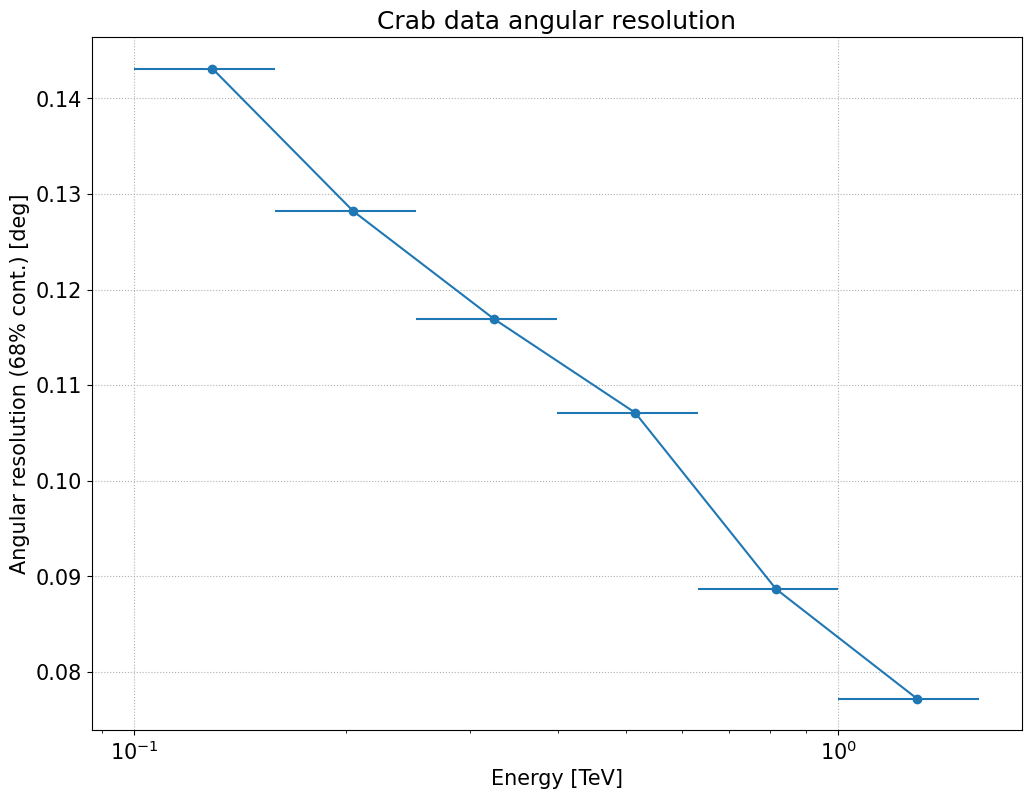

In [56]:
plt.figure()

plt.title(f"Crab data angular resolution")
plt.ylabel("Angular resolution (68% cont.) [deg]")
plt.xlabel("Energy [TeV]")
plt.semilogx()
plt.grid()


plt.errorbar(
    x=energy_bins_center,
    y=angres_Crab,
    xerr=energy_bins_width,
    label="Crab",
    marker="o",
)
